In [268]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.cuda.manual_seed_all(3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pairs = [('VO','IWB'), 
         ('VO','SPY'), 
         ('VO','SCHX'), 
         ('VO','SPLG'), 
         ('VO', 'IVV'),
         ('VO', 'VOO'), 
         ('DVY','IWR'), 
         ('SCHV', 'SPHQ'), 
         ('IWR','DIA'), 
         ('DVY','OEF'), 
         ('VTV', 'SPHQ'), 
         ('RSP', 'DIA'), 
         ('VO', 'DIA'), 
         ('DVY', 'FVD'), 
         ('DVY','VYM')] # closing

downloadable_tickers = [ticker for pair in pairs for ticker in pair]

training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_44652/3835857497.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(downloadable_tickers, start = '2015-01-01', end = '2020-01-01')['Close']
[*********************100%***********************]  17 of 17 completed
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_44652/3835857497.py:40: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(downloadable_tickers, start = '2020-01-02', end = '2024-12-31')['Close']
[*********************100%***********************]  17 of 17 completed


In [269]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def rolling_zscore(series, window = 60):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

def predict_mean_reversion_label(
    spread,
    z_window = 60,
    horizon = 10,
    entry_z = 1.0,
    min_pnl = 0.0,
):

    z = rolling_zscore(spread, window=z_window)

    direction = -np.sign(z)

    future_spread = spread.shift(-horizon)

    spread_change = future_spread - spread
    pnl = direction * spread_change

    cond_entry = z.abs() >= entry_z

    labels = ((cond_entry) & (pnl > min_pnl)).astype(float)

    labels = labels.iloc[:-horizon]

    labels = labels.dropna()

    return labels

def create_features(spread, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = rolling_zscore(df['spread'])

    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag5'] = df['z-score'].shift(5)

    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

window = 5

for etf1, etf2 in pairs:

    pair_name = f'{etf1}_{etf2}'

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, window = window)
    test_features  = create_features(testing_spread, window = window)

    train_labels = predict_mean_reversion_label(
        training_spread,
        z_window = 60,
        horizon = 10,
        entry_z = 1.0,
        min_pnl = 0.0,
    )

    test_labels = predict_mean_reversion_label(
        testing_spread,
        z_window = 60,
        horizon = 10,
        entry_z = 1.0,
        min_pnl = 0.0,
    )

    train_idx = train_features.index.intersection(train_labels.index)
    test_idx  = test_features.index.intersection(test_labels.index)

    train_features = train_features.loc[train_idx].copy()
    test_features  = test_features.loc[test_idx].copy()

    train_labels = train_labels.loc[train_idx]
    test_labels  = test_labels.loc[test_idx]

    train_features['label'] = train_labels
    test_features['label']  = test_labels

    train_features = train_features.dropna(subset=['label'])
    test_features  = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name]  = test_features.drop(columns=['label'])
    y_test_dict[pair_name]  = test_features['label']

for pair_name in y_train_dict:
    print(pair_name, 
          "train_label_mean:", y_train_dict[pair_name].mean(), 
          "test_label_mean:",  y_test_dict[pair_name].mean())

training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

VO_IWB train_label_mean: 0.2939189189189189 test_label_mean: 0.27218934911242604
VO_SPY train_label_mean: 0.29307432432432434 test_label_mean: 0.27303465765004226
VO_SCHX train_label_mean: 0.2947635135135135 test_label_mean: 0.2704987320371936
VO_SPLG train_label_mean: 0.29138513513513514 test_label_mean: 0.2688081149619611
VO_IVV train_label_mean: 0.2922297297297297 test_label_mean: 0.2704987320371936
VO_VOO train_label_mean: 0.2981418918918919 test_label_mean: 0.2713440405748098
DVY_IWR train_label_mean: 0.3015202702702703 test_label_mean: 0.28233305156382077
SCHV_SPHQ train_label_mean: 0.2829391891891892 test_label_mean: 0.28233305156382077
IWR_DIA train_label_mean: 0.2846283783783784 test_label_mean: 0.28317836010143704
DVY_OEF train_label_mean: 0.31841216216216217 test_label_mean: 0.2781065088757396
VTV_SPHQ train_label_mean: 0.2635135135135135 test_label_mean: 0.28402366863905326
RSP_DIA train_label_mean: 0.2972972972972973 test_label_mean: 0.2764158918005072
VO_DIA train_label_m

In [270]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [271]:
class ClassificationLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out.squeeze()

In [272]:
def train_model(model, train_loader, criterion, optimizer, epochs = 30, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [273]:
def evaluate_model(model, pair_name, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy: ", accuracy)
    return y_true, y_pred, y_pred_label

In [274]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x = aligned_spread.index, y = aligned_spread.values, label = 'Spread', color = 'black')
    sns.scatterplot(x = predicted_points.index, y = predicted_points.values, color = 'green', label = 'Predicted Reversion', s = 100, marker = 'o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [275]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [276]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [277]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, epochs, device = 'cpu'):

    hidden_size = 32
    lr = 0.01
    num_layers = 1
    window_size = 5
    batch_size = 32

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype = torch.float32)
    y_train = torch.tensor(y_seq, dtype = torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype = torch.float32)
    y_test = torch.tensor(y_test_seq, dtype = torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)
    
    return model, y_true, y_pred


Training model for pair: VO_IWB
Epoch 1/20 - Loss: 0.9610
Epoch 2/20 - Loss: 0.8975
Epoch 3/20 - Loss: 0.8475
Epoch 4/20 - Loss: 0.8232
Epoch 5/20 - Loss: 0.8046
Epoch 6/20 - Loss: 0.7915
Epoch 7/20 - Loss: 0.7689
Epoch 8/20 - Loss: 0.7477
Epoch 9/20 - Loss: 0.7434
Epoch 10/20 - Loss: 0.7309
Epoch 11/20 - Loss: 0.7209
Epoch 12/20 - Loss: 0.7094
Epoch 13/20 - Loss: 0.7055
Epoch 14/20 - Loss: 0.6787
Epoch 15/20 - Loss: 0.6707
Epoch 16/20 - Loss: 0.6626
Epoch 17/20 - Loss: 0.6431
Epoch 18/20 - Loss: 0.6333
Epoch 19/20 - Loss: 0.6229
Epoch 20/20 - Loss: 0.6257

Evaluating model for pair: VO_IWB
Test Accuracy:  0.6816638370118846


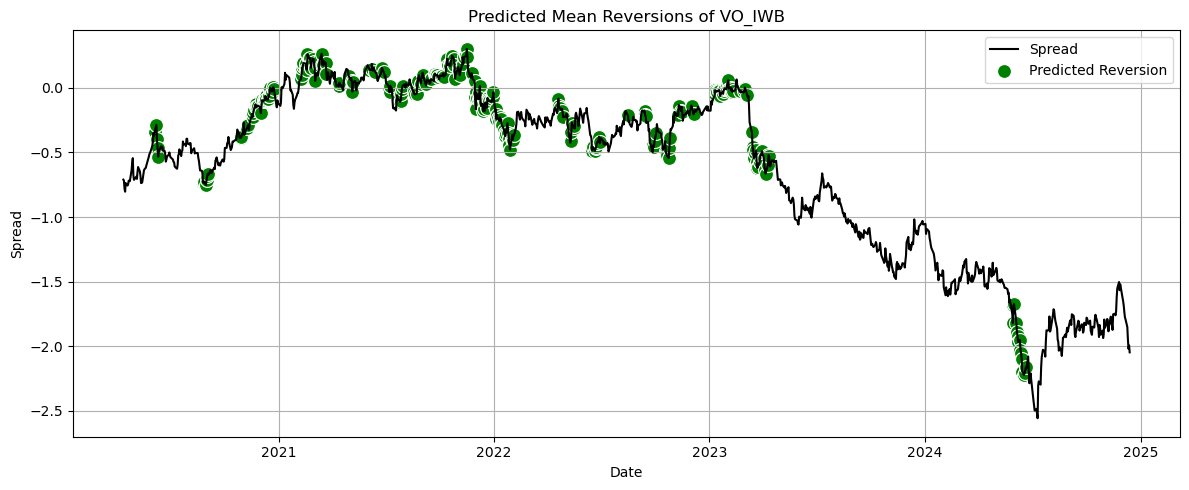

Confusion Matrix:
[[694 165]
 [210 109]]
F1 Score: 0.3676

Training model for pair: VO_SPY
Epoch 1/20 - Loss: 0.9724
Epoch 2/20 - Loss: 0.8929
Epoch 3/20 - Loss: 0.8505
Epoch 4/20 - Loss: 0.8198
Epoch 5/20 - Loss: 0.7976
Epoch 6/20 - Loss: 0.7881
Epoch 7/20 - Loss: 0.7656
Epoch 8/20 - Loss: 0.7626
Epoch 9/20 - Loss: 0.7489
Epoch 10/20 - Loss: 0.7417
Epoch 11/20 - Loss: 0.7180
Epoch 12/20 - Loss: 0.7152
Epoch 13/20 - Loss: 0.7005
Epoch 14/20 - Loss: 0.6993
Epoch 15/20 - Loss: 0.6846
Epoch 16/20 - Loss: 0.6518
Epoch 17/20 - Loss: 0.6259
Epoch 18/20 - Loss: 0.6198
Epoch 19/20 - Loss: 0.6328
Epoch 20/20 - Loss: 0.6212

Evaluating model for pair: VO_SPY
Test Accuracy:  0.7368421052631579


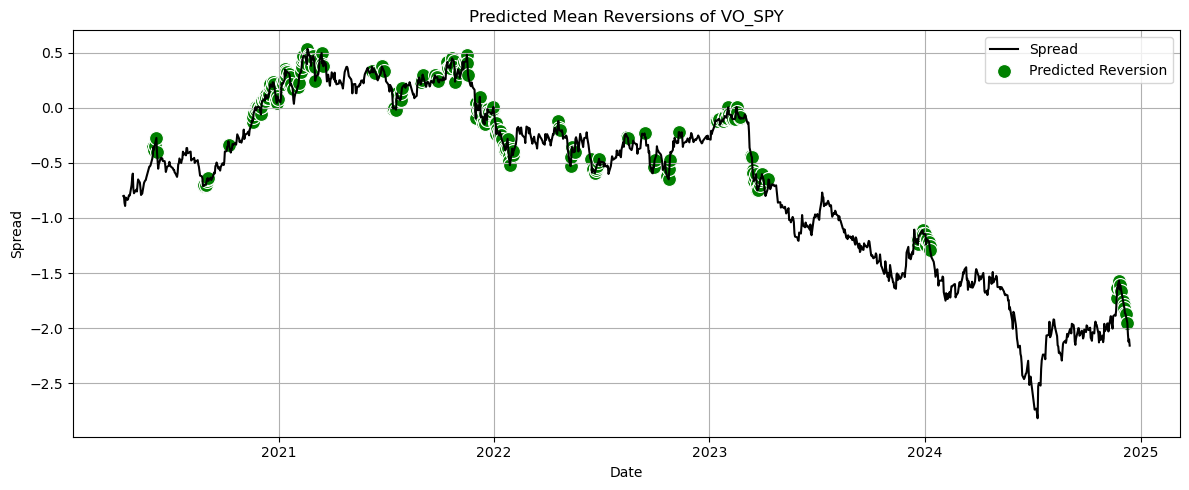

Confusion Matrix:
[[735 123]
 [187 133]]
F1 Score: 0.4618

Training model for pair: VO_SCHX
Epoch 1/20 - Loss: 0.9591
Epoch 2/20 - Loss: 0.9027
Epoch 3/20 - Loss: 0.8661
Epoch 4/20 - Loss: 0.8306
Epoch 5/20 - Loss: 0.8045
Epoch 6/20 - Loss: 0.7890
Epoch 7/20 - Loss: 0.7786
Epoch 8/20 - Loss: 0.7472
Epoch 9/20 - Loss: 0.7446
Epoch 10/20 - Loss: 0.7214
Epoch 11/20 - Loss: 0.7087
Epoch 12/20 - Loss: 0.7009
Epoch 13/20 - Loss: 0.7031
Epoch 14/20 - Loss: 0.6791
Epoch 15/20 - Loss: 0.6556
Epoch 16/20 - Loss: 0.6471
Epoch 17/20 - Loss: 0.6166
Epoch 18/20 - Loss: 0.6087
Epoch 19/20 - Loss: 0.5880
Epoch 20/20 - Loss: 0.5967

Evaluating model for pair: VO_SCHX
Test Accuracy:  0.7181663837011885


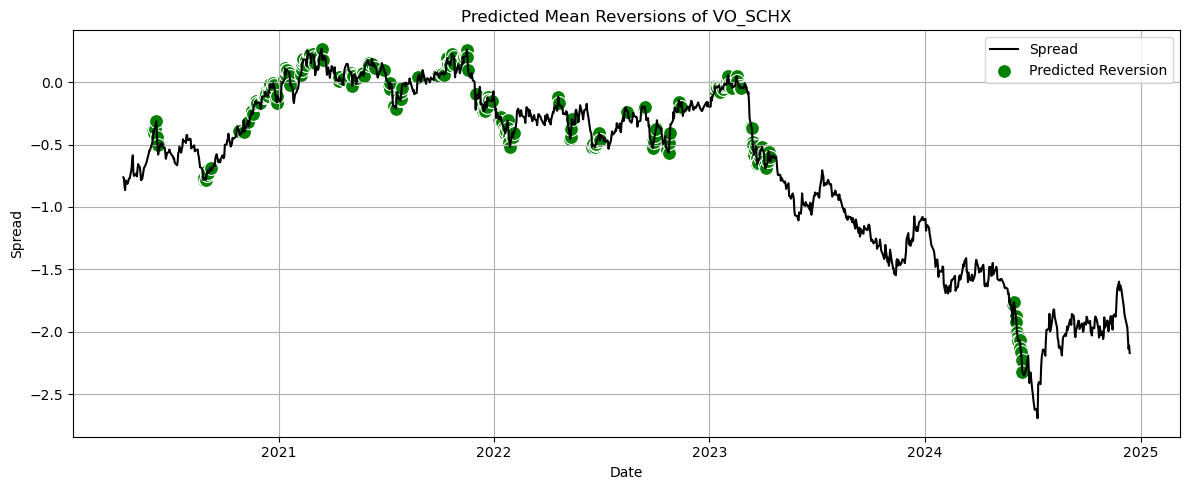

Confusion Matrix:
[[734 127]
 [205 112]]
F1 Score: 0.4029

Training model for pair: VO_SPLG
Epoch 1/20 - Loss: 0.9698
Epoch 2/20 - Loss: 0.9257
Epoch 3/20 - Loss: 0.8868
Epoch 4/20 - Loss: 0.8576
Epoch 5/20 - Loss: 0.8362
Epoch 6/20 - Loss: 0.8189
Epoch 7/20 - Loss: 0.8069
Epoch 8/20 - Loss: 0.7885
Epoch 9/20 - Loss: 0.7824
Epoch 10/20 - Loss: 0.7691
Epoch 11/20 - Loss: 0.7578
Epoch 12/20 - Loss: 0.7278
Epoch 13/20 - Loss: 0.7654
Epoch 14/20 - Loss: 0.7208
Epoch 15/20 - Loss: 0.6852
Epoch 16/20 - Loss: 0.6594
Epoch 17/20 - Loss: 0.6478
Epoch 18/20 - Loss: 0.6360
Epoch 19/20 - Loss: 0.6038
Epoch 20/20 - Loss: 0.5774

Evaluating model for pair: VO_SPLG
Test Accuracy:  0.700339558573854


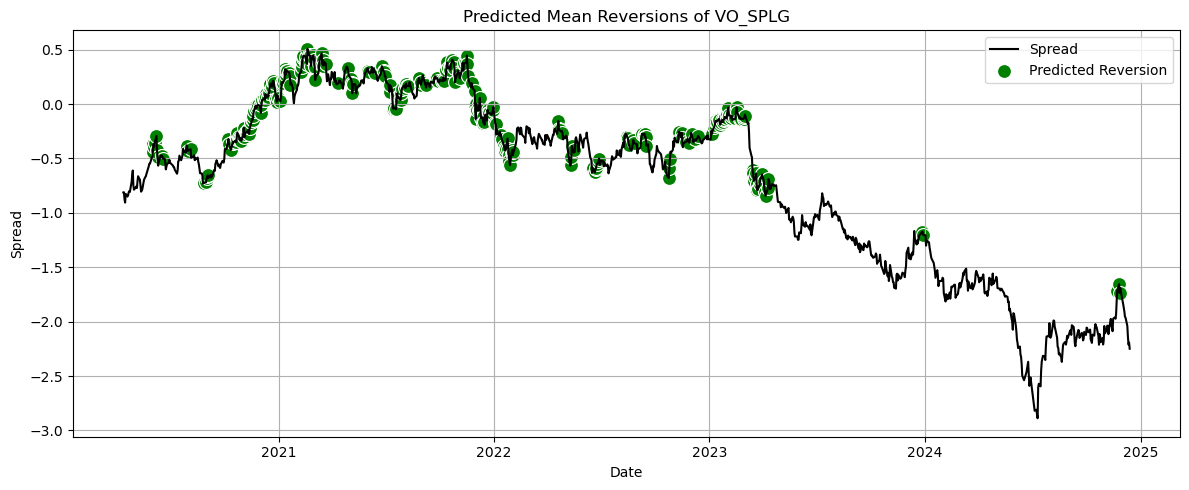

Confusion Matrix:
[[690 173]
 [180 135]]
F1 Score: 0.4334

Training model for pair: VO_IVV
Epoch 1/20 - Loss: 0.9704
Epoch 2/20 - Loss: 0.9059
Epoch 3/20 - Loss: 0.8684
Epoch 4/20 - Loss: 0.8355
Epoch 5/20 - Loss: 0.8146
Epoch 6/20 - Loss: 0.7981
Epoch 7/20 - Loss: 0.7719
Epoch 8/20 - Loss: 0.7702
Epoch 9/20 - Loss: 0.7436
Epoch 10/20 - Loss: 0.7484
Epoch 11/20 - Loss: 0.7245
Epoch 12/20 - Loss: 0.7455
Epoch 13/20 - Loss: 0.7186
Epoch 14/20 - Loss: 0.7078
Epoch 15/20 - Loss: 0.6775
Epoch 16/20 - Loss: 0.6620
Epoch 17/20 - Loss: 0.6446
Epoch 18/20 - Loss: 0.6430
Epoch 19/20 - Loss: 0.6154
Epoch 20/20 - Loss: 0.5926

Evaluating model for pair: VO_IVV
Test Accuracy:  0.7275042444821732


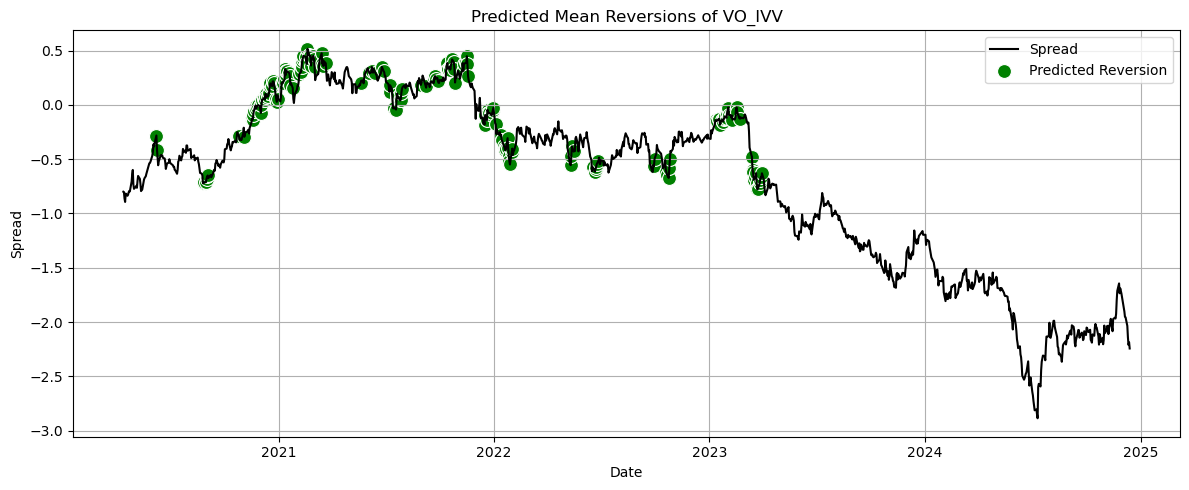

Confusion Matrix:
[[761 100]
 [221  96]]
F1 Score: 0.3743

Training model for pair: VO_VOO
Epoch 1/20 - Loss: 0.9668
Epoch 2/20 - Loss: 0.8998
Epoch 3/20 - Loss: 0.8636
Epoch 4/20 - Loss: 0.8241
Epoch 5/20 - Loss: 0.8089
Epoch 6/20 - Loss: 0.8041
Epoch 7/20 - Loss: 0.7768
Epoch 8/20 - Loss: 0.7767
Epoch 9/20 - Loss: 0.7614
Epoch 10/20 - Loss: 0.7507
Epoch 11/20 - Loss: 0.7413
Epoch 12/20 - Loss: 0.7273
Epoch 13/20 - Loss: 0.7138
Epoch 14/20 - Loss: 0.7014
Epoch 15/20 - Loss: 0.6761
Epoch 16/20 - Loss: 0.6588
Epoch 17/20 - Loss: 0.6432
Epoch 18/20 - Loss: 0.6487
Epoch 19/20 - Loss: 0.6167
Epoch 20/20 - Loss: 0.6079

Evaluating model for pair: VO_VOO
Test Accuracy:  0.7122241086587436


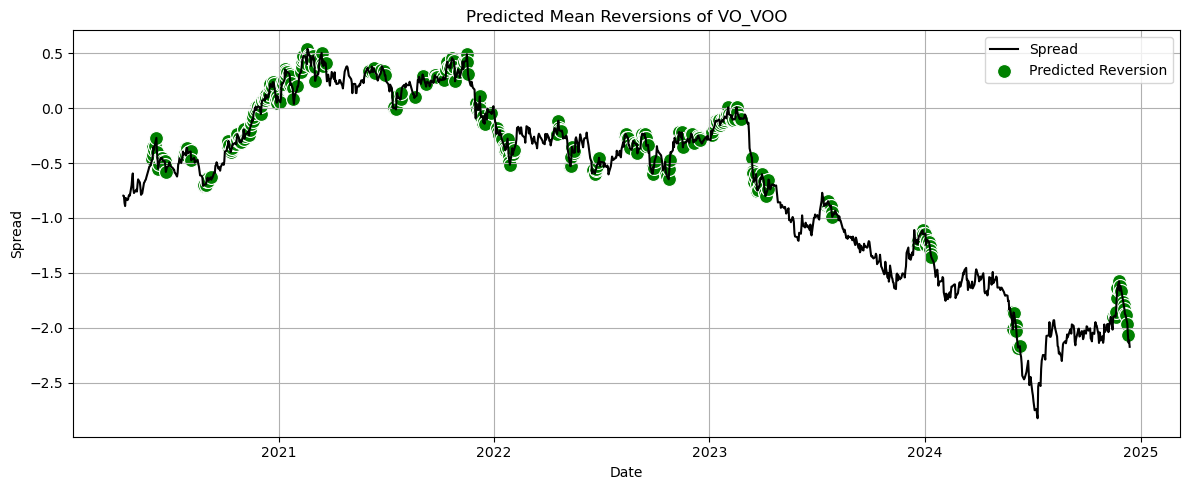

Confusion Matrix:
[[664 196]
 [143 175]]
F1 Score: 0.5080

Training model for pair: DVY_IWR
Epoch 1/20 - Loss: 0.9390
Epoch 2/20 - Loss: 0.8839
Epoch 3/20 - Loss: 0.8475
Epoch 4/20 - Loss: 0.8114
Epoch 5/20 - Loss: 0.7869
Epoch 6/20 - Loss: 0.7673
Epoch 7/20 - Loss: 0.7588
Epoch 8/20 - Loss: 0.7292
Epoch 9/20 - Loss: 0.7061
Epoch 10/20 - Loss: 0.6886
Epoch 11/20 - Loss: 0.6775
Epoch 12/20 - Loss: 0.6969
Epoch 13/20 - Loss: 0.6756
Epoch 14/20 - Loss: 0.6606
Epoch 15/20 - Loss: 0.6300
Epoch 16/20 - Loss: 0.6101
Epoch 17/20 - Loss: 0.6063
Epoch 18/20 - Loss: 0.6083
Epoch 19/20 - Loss: 0.6050
Epoch 20/20 - Loss: 0.6325

Evaluating model for pair: DVY_IWR
Test Accuracy:  0.6740237691001698


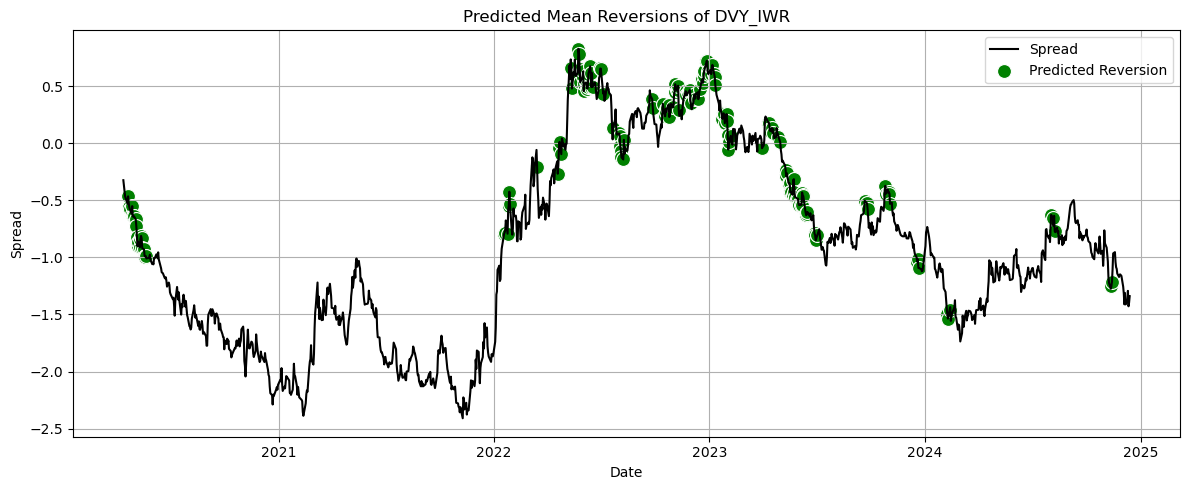

Confusion Matrix:
[[729 115]
 [269  65]]
F1 Score: 0.2529

Training model for pair: SCHV_SPHQ
Epoch 1/20 - Loss: 0.9821
Epoch 2/20 - Loss: 0.9585
Epoch 3/20 - Loss: 0.9274
Epoch 4/20 - Loss: 0.9072
Epoch 5/20 - Loss: 0.8891
Epoch 6/20 - Loss: 0.8726
Epoch 7/20 - Loss: 0.8582
Epoch 8/20 - Loss: 0.8455
Epoch 9/20 - Loss: 0.8262
Epoch 10/20 - Loss: 0.8154
Epoch 11/20 - Loss: 0.8028
Epoch 12/20 - Loss: 0.7915
Epoch 13/20 - Loss: 0.7778
Epoch 14/20 - Loss: 0.7711
Epoch 15/20 - Loss: 0.7422
Epoch 16/20 - Loss: 0.7337
Epoch 17/20 - Loss: 0.7304
Epoch 18/20 - Loss: 0.7044
Epoch 19/20 - Loss: 0.7015
Epoch 20/20 - Loss: 0.6674

Evaluating model for pair: SCHV_SPHQ
Test Accuracy:  0.7071307300509337


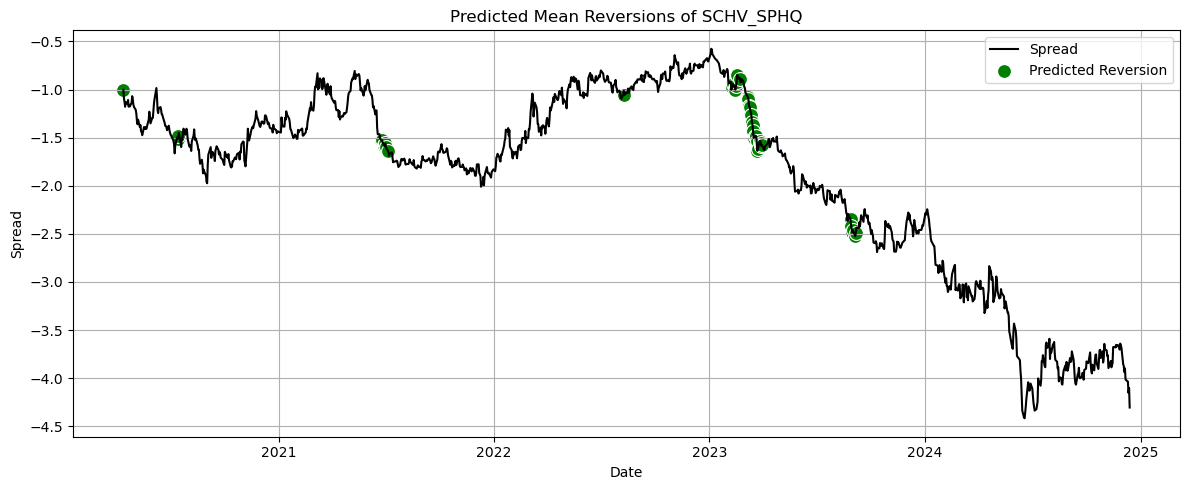

Confusion Matrix:
[[815  30]
 [315  18]]
F1 Score: 0.0945

Training model for pair: IWR_DIA
Epoch 1/20 - Loss: 0.9777
Epoch 2/20 - Loss: 0.9205
Epoch 3/20 - Loss: 0.8900
Epoch 4/20 - Loss: 0.8599
Epoch 5/20 - Loss: 0.8327
Epoch 6/20 - Loss: 0.8083
Epoch 7/20 - Loss: 0.7969
Epoch 8/20 - Loss: 0.7887
Epoch 9/20 - Loss: 0.7907
Epoch 10/20 - Loss: 0.7849
Epoch 11/20 - Loss: 0.7708
Epoch 12/20 - Loss: 0.7817
Epoch 13/20 - Loss: 0.7443
Epoch 14/20 - Loss: 0.7244
Epoch 15/20 - Loss: 0.7016
Epoch 16/20 - Loss: 0.6856
Epoch 17/20 - Loss: 0.6759
Epoch 18/20 - Loss: 0.6746
Epoch 19/20 - Loss: 0.6628
Epoch 20/20 - Loss: 0.6483

Evaluating model for pair: IWR_DIA
Test Accuracy:  0.44227504244482174


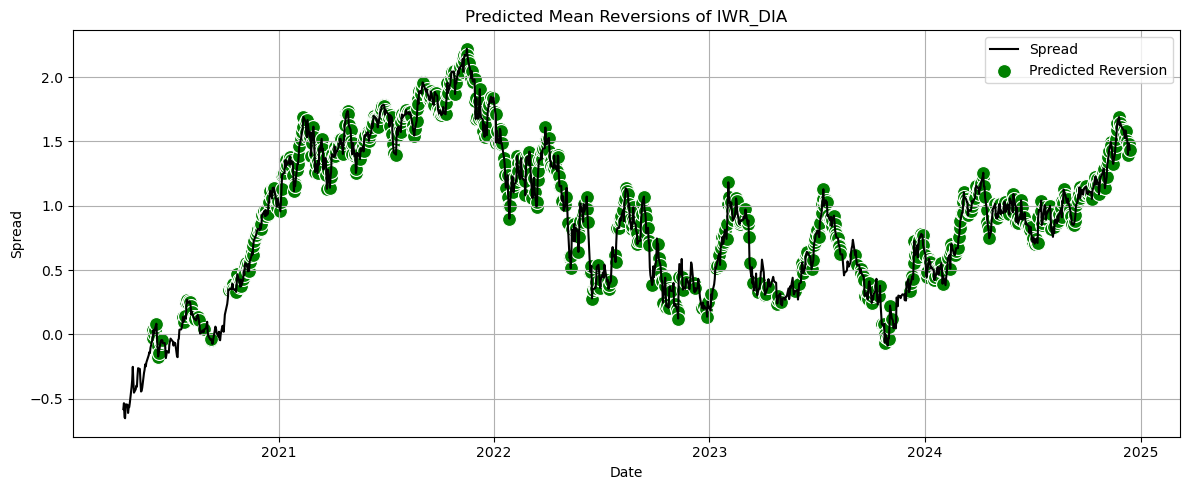

Confusion Matrix:
[[234 613]
 [ 44 287]]
F1 Score: 0.4663

Training model for pair: DVY_OEF
Epoch 1/20 - Loss: 0.9375
Epoch 2/20 - Loss: 0.8984
Epoch 3/20 - Loss: 0.8751
Epoch 4/20 - Loss: 0.8558
Epoch 5/20 - Loss: 0.8309
Epoch 6/20 - Loss: 0.8129
Epoch 7/20 - Loss: 0.7935
Epoch 8/20 - Loss: 0.7814
Epoch 9/20 - Loss: 0.7715
Epoch 10/20 - Loss: 0.7559
Epoch 11/20 - Loss: 0.7464
Epoch 12/20 - Loss: 0.7315
Epoch 13/20 - Loss: 0.7208
Epoch 14/20 - Loss: 0.6932
Epoch 15/20 - Loss: 0.6795
Epoch 16/20 - Loss: 0.6822
Epoch 17/20 - Loss: 0.6685
Epoch 18/20 - Loss: 0.6376
Epoch 19/20 - Loss: 0.6131
Epoch 20/20 - Loss: 0.6076

Evaluating model for pair: DVY_OEF
Test Accuracy:  0.6935483870967742


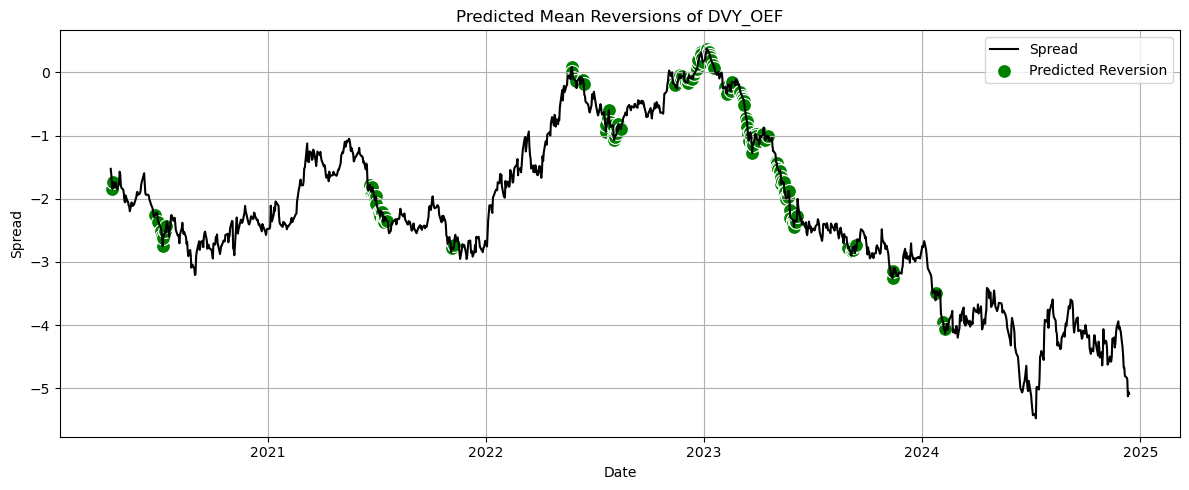

Confusion Matrix:
[[758  91]
 [270  59]]
F1 Score: 0.2463

Training model for pair: VTV_SPHQ
Epoch 1/20 - Loss: 1.0196
Epoch 2/20 - Loss: 0.9539
Epoch 3/20 - Loss: 0.9196
Epoch 4/20 - Loss: 0.8921
Epoch 5/20 - Loss: 0.8755
Epoch 6/20 - Loss: 0.8627
Epoch 7/20 - Loss: 0.8408
Epoch 8/20 - Loss: 0.8293
Epoch 9/20 - Loss: 0.8067
Epoch 10/20 - Loss: 0.7833
Epoch 11/20 - Loss: 0.7838
Epoch 12/20 - Loss: 0.7679
Epoch 13/20 - Loss: 0.7827
Epoch 14/20 - Loss: 0.7648
Epoch 15/20 - Loss: 0.7500
Epoch 16/20 - Loss: 0.7443
Epoch 17/20 - Loss: 0.7321
Epoch 18/20 - Loss: 0.6913
Epoch 19/20 - Loss: 0.6856
Epoch 20/20 - Loss: 0.6605

Evaluating model for pair: VTV_SPHQ
Test Accuracy:  0.7275042444821732


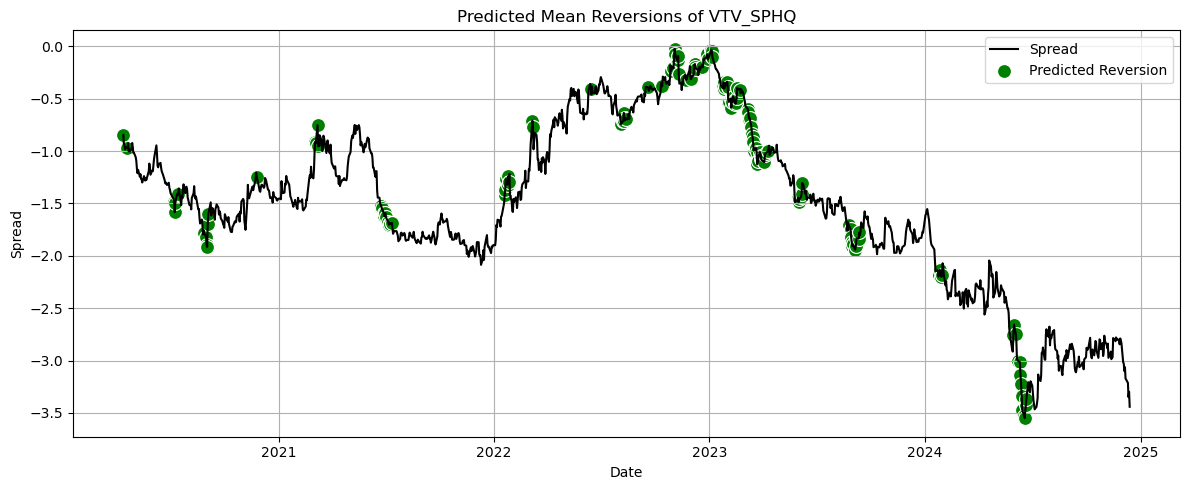

Confusion Matrix:
[[777  66]
 [255  80]]
F1 Score: 0.3326

Training model for pair: RSP_DIA
Epoch 1/20 - Loss: 0.9567
Epoch 2/20 - Loss: 0.8888
Epoch 3/20 - Loss: 0.8438
Epoch 4/20 - Loss: 0.8170
Epoch 5/20 - Loss: 0.8016
Epoch 6/20 - Loss: 0.7953
Epoch 7/20 - Loss: 0.7682
Epoch 8/20 - Loss: 0.7593
Epoch 9/20 - Loss: 0.7436
Epoch 10/20 - Loss: 0.7364
Epoch 11/20 - Loss: 0.7152
Epoch 12/20 - Loss: 0.6972
Epoch 13/20 - Loss: 0.6872
Epoch 14/20 - Loss: 0.6651
Epoch 15/20 - Loss: 0.6641
Epoch 16/20 - Loss: 0.6597
Epoch 17/20 - Loss: 0.6295
Epoch 18/20 - Loss: 0.6014
Epoch 19/20 - Loss: 0.5835
Epoch 20/20 - Loss: 0.5646

Evaluating model for pair: RSP_DIA
Test Accuracy:  0.4380305602716469


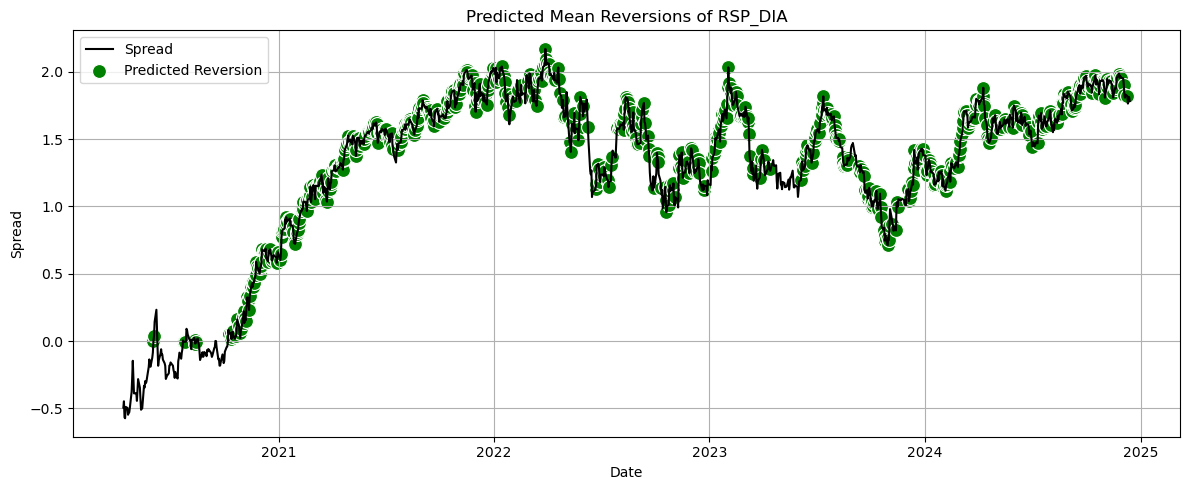

Confusion Matrix:
[[275 579]
 [ 83 241]]
F1 Score: 0.4213

Training model for pair: VO_DIA
Epoch 1/20 - Loss: 0.9765
Epoch 2/20 - Loss: 0.9166
Epoch 3/20 - Loss: 0.8585
Epoch 4/20 - Loss: 0.8370
Epoch 5/20 - Loss: 0.8343
Epoch 6/20 - Loss: 0.8082
Epoch 7/20 - Loss: 0.7989
Epoch 8/20 - Loss: 0.7858
Epoch 9/20 - Loss: 0.7845
Epoch 10/20 - Loss: 0.7618
Epoch 11/20 - Loss: 0.7576
Epoch 12/20 - Loss: 0.7588
Epoch 13/20 - Loss: 0.7517
Epoch 14/20 - Loss: 0.7366
Epoch 15/20 - Loss: 0.7157
Epoch 16/20 - Loss: 0.7143
Epoch 17/20 - Loss: 0.7039
Epoch 18/20 - Loss: 0.7281
Epoch 19/20 - Loss: 0.6956
Epoch 20/20 - Loss: 0.6849

Evaluating model for pair: VO_DIA
Test Accuracy:  0.4694397283531409


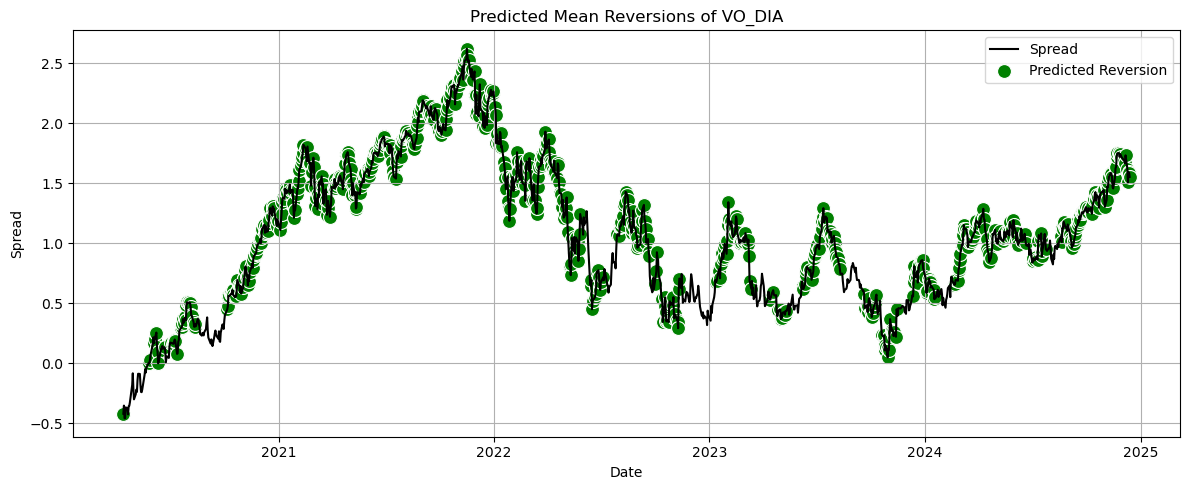

Confusion Matrix:
[[273 578]
 [ 47 280]]
F1 Score: 0.4726

Training model for pair: DVY_FVD
Epoch 1/20 - Loss: 0.9690
Epoch 2/20 - Loss: 0.9297
Epoch 3/20 - Loss: 0.9116
Epoch 4/20 - Loss: 0.8937
Epoch 5/20 - Loss: 0.8781
Epoch 6/20 - Loss: 0.8648
Epoch 7/20 - Loss: 0.8532
Epoch 8/20 - Loss: 0.8412
Epoch 9/20 - Loss: 0.8286
Epoch 10/20 - Loss: 0.8243
Epoch 11/20 - Loss: 0.8114
Epoch 12/20 - Loss: 0.7975
Epoch 13/20 - Loss: 0.7887
Epoch 14/20 - Loss: 0.7773
Epoch 15/20 - Loss: 0.7496
Epoch 16/20 - Loss: 0.7268
Epoch 17/20 - Loss: 0.7122
Epoch 18/20 - Loss: 0.6941
Epoch 19/20 - Loss: 0.7060
Epoch 20/20 - Loss: 0.6545

Evaluating model for pair: DVY_FVD
Test Accuracy:  0.6629881154499151


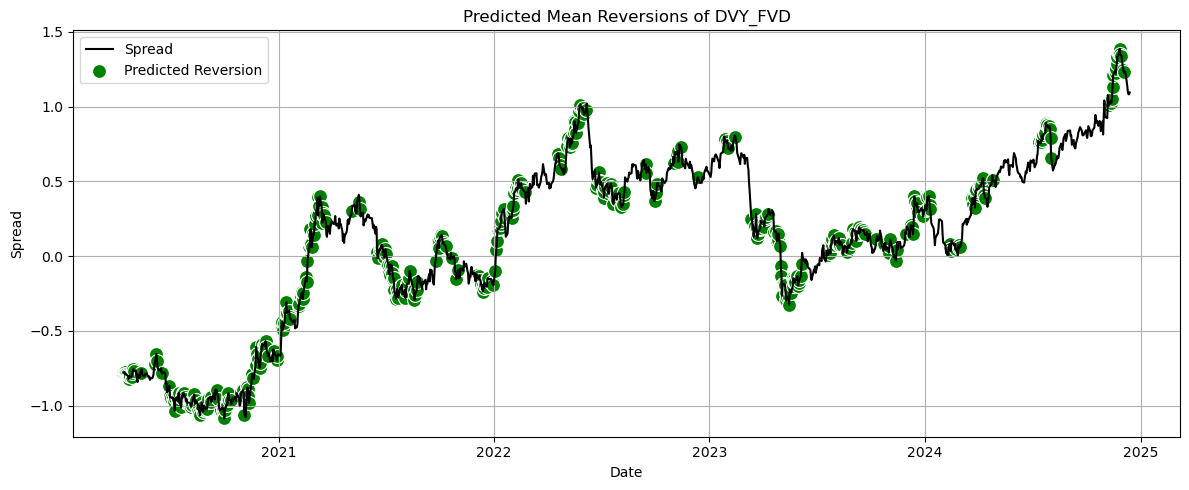

Confusion Matrix:
[[557 276]
 [121 224]]
F1 Score: 0.5302

Training model for pair: DVY_VYM
Epoch 1/20 - Loss: 0.9517
Epoch 2/20 - Loss: 0.9062
Epoch 3/20 - Loss: 0.8833
Epoch 4/20 - Loss: 0.8630
Epoch 5/20 - Loss: 0.8450
Epoch 6/20 - Loss: 0.8287
Epoch 7/20 - Loss: 0.8145
Epoch 8/20 - Loss: 0.8032
Epoch 9/20 - Loss: 0.7817
Epoch 10/20 - Loss: 0.7632
Epoch 11/20 - Loss: 0.7364
Epoch 12/20 - Loss: 0.7271
Epoch 13/20 - Loss: 0.7166
Epoch 14/20 - Loss: 0.6981
Epoch 15/20 - Loss: 0.6622
Epoch 16/20 - Loss: 0.6699
Epoch 17/20 - Loss: 0.6774
Epoch 18/20 - Loss: 0.6661
Epoch 19/20 - Loss: 0.6135
Epoch 20/20 - Loss: 0.5723

Evaluating model for pair: DVY_VYM
Test Accuracy:  0.597623089983022


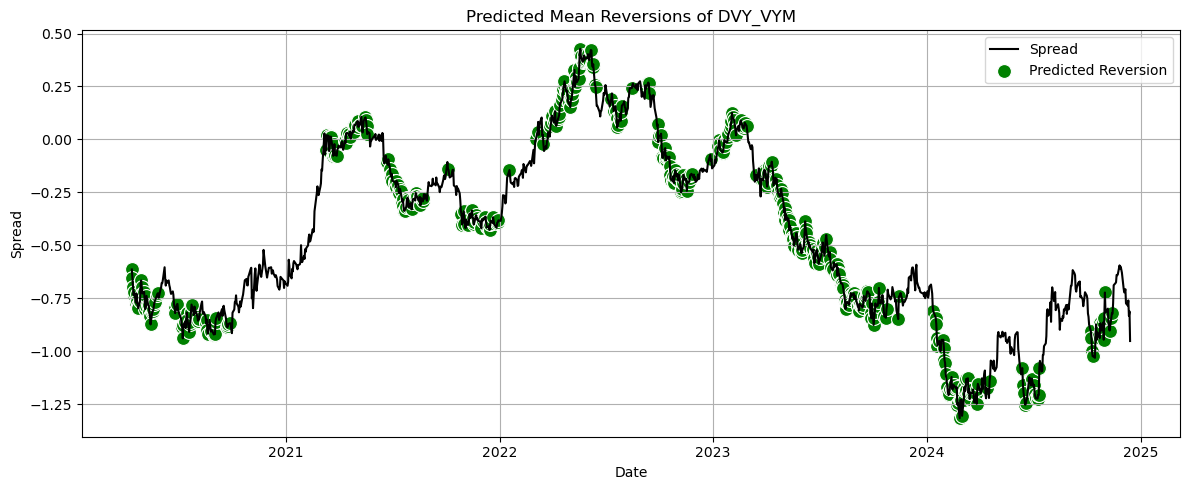

Confusion Matrix:
[[513 343]
 [131 191]]
F1 Score: 0.4463
{'VO_IWB': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
), 'y_true': array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1178, 1), dtype=float32), 'y_pred': array([0.02525887, 0.01705741, 0.01212526, ..., 0.00771346, 0.01490705,
       0.02118598], shape=(1178,), dtype=float32)}, 'VO_SPY': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
), 'y_true': array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1178, 1), dtype=float32), 'y_pred': array([0.00207307, 0.00252278, 0.00426381, ..., 0.02358815, 0.00826649,
       0.00760967], shape=(1178,), dtype=float32)}, 'VO_SCHX': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32,

In [278]:
results = {}

for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        epochs = 20,
        device = 'cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

print(results)

In [279]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        price_df = testing_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [280]:
def compute_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [281]:
def plot_combined_equity_and_drawdown(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(equity, label='Combined Equity')
    ax[0].set_title("Combined Equity Curve")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(drawdown, color='red', label='Drawdown')
    ax[1].set_title("Drawdown Over Time")
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()


In [282]:
def simulate_portfolio(
    X_df, probs, y_pred_label, prices_df,
    initial_cash_per_pair = 100.0,
    holding_period = 10,
    entry_threshold = 0.8,
):
    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['prob'] = probs
    df['label'] = y_pred_label
    df = df.join(prices_df)

    # print(np.min(probs), np.max(probs), np.mean(probs))

    prob_threshold = np.quantile(probs, 0.85)

    cash = initial_cash_per_pair
    equity = pd.Series(index = df.index, dtype = float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prob = row['prob']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        if (prob >= prob_threshold and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            notional = cash
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "prob": prob,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace = True)
    return equity, trades

In [283]:
def run_simulation(results, X_test_dict, testing_data):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}
    pair_drawdowns = {}
    pair_equities = {}

    plt.figure(figsize=(12, 6))

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred = model_info['y_pred']

        probs = torch.sigmoid(torch.tensor(y_pred)).squeeze().numpy()
        y_pred_label = (probs > 0.5).astype(int)

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        equity, trades = simulate_portfolio(X_test_df, probs, y_pred_label, prices_df)

        pair_equities[pair_name] = equity
        max_dd, _ = compute_max_drawdown(equity)
        pair_drawdowns[pair_name] = max_dd

        pair_returns = equity.pct_change().dropna()

        if pair_returns.std() != 0:
            sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252)
        else:
            sharpe = np.nan

        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            equity.name = pair_name
            combined_equity = equity.to_frame()
        else:
            equity.name = pair_name
            combined_equity = pd.concat([combined_equity, equity], axis=1)

        sns.lineplot(x = equity.index, y = equity.values, label = pair_name)

    combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')
    combined_equity['Total'] = combined_equity.sum(axis=1)

    plt.title("LSTM Equity Curve by Pair", fontsize=15, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value ($)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"{pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity['Total'].pct_change().dropna()
    sharpe_ratio = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {sharpe_ratio:.2f}")

    print("\nMax Drawdowns by Pair:")
    for pair, drawdown in pair_drawdowns.items():
        print(f"{pair}: Max Drawdown = {drawdown:.2%}")

    max_dd, drawdowns = compute_max_drawdown(combined_equity['Total'])
    print(f"\nTotal Max Drawdown: {max_dd:.2%}")

    plot_combined_equity_and_drawdown(combined_equity['Total'])

    for pair in combined_equity.columns:
        print(f"Pair: {pair}")
        print(combined_equity[pair].tail(10))  # show last 10 rows for this pair
        print("-" * 40)

    cumulative_equity = combined_equity['Total']
    cumulative_equity.to_csv("equity_curves/lstm_equity.csv", header = ["Portfolio Value"])

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_44652/579190202.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')


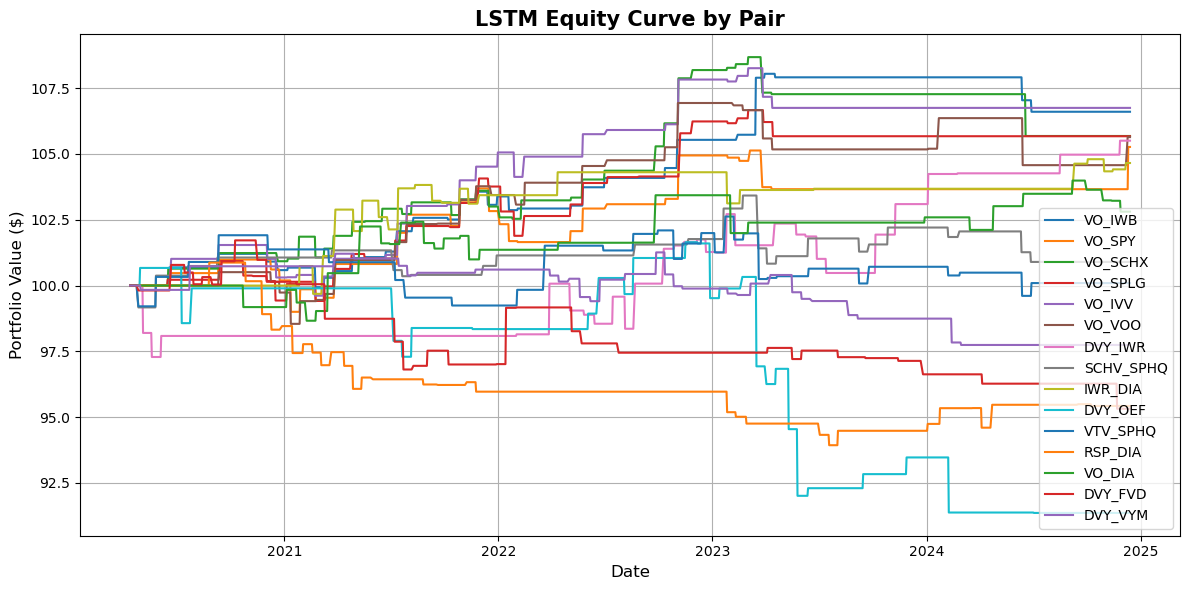


Final Portfolio Value: $1,529.44

Trade Summary:
  VO_IWB: 31 trades | Total PnL: $6.60 | Avg PnL: $0.21
  VO_SPY: 29 trades | Total PnL: $5.27 | Avg PnL: $0.18
  VO_SCHX: 33 trades | Total PnL: $5.68 | Avg PnL: $0.17
  VO_SPLG: 33 trades | Total PnL: $5.67 | Avg PnL: $0.17
  VO_IVV: 27 trades | Total PnL: $6.75 | Avg PnL: $0.25
  VO_VOO: 29 trades | Total PnL: $5.64 | Avg PnL: $0.19
  DVY_IWR: 30 trades | Total PnL: $5.51 | Avg PnL: $0.18
  SCHV_SPHQ: 25 trades | Total PnL: $0.90 | Avg PnL: $0.04
  IWR_DIA: 24 trades | Total PnL: $4.66 | Avg PnL: $0.19
  DVY_OEF: 26 trades | Total PnL: $-8.64 | Avg PnL: $-0.33
  VTV_SPHQ: 31 trades | Total PnL: $0.09 | Avg PnL: $0.00
  RSP_DIA: 31 trades | Total PnL: $-4.57 | Avg PnL: $-0.15
  VO_DIA: 31 trades | Total PnL: $2.81 | Avg PnL: $0.09
  DVY_FVD: 33 trades | Total PnL: $-4.68 | Avg PnL: $-0.14
  DVY_VYM: 30 trades | Total PnL: $-2.26 | Avg PnL: $-0.08

Year-End Portfolio Values:
                VO_IWB      VO_SPY     VO_SCHX     VO_SPLG   

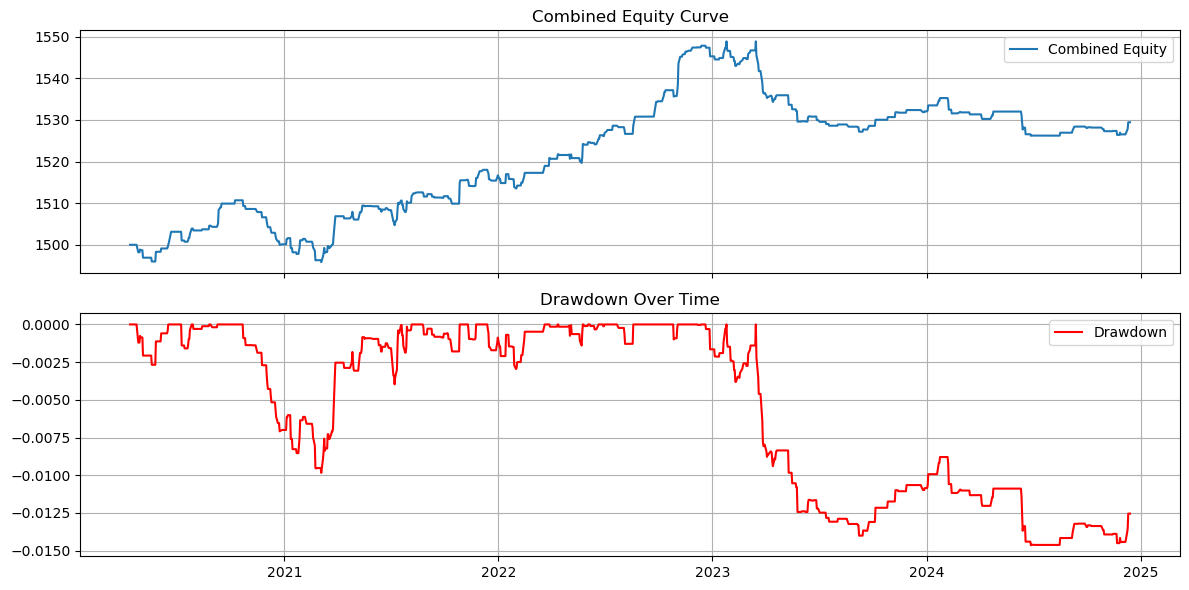

Pair: VO_IWB
Date
2024-12-02    106.604166
2024-12-03    106.604166
2024-12-04    106.604166
2024-12-05    106.604166
2024-12-06    106.604166
2024-12-09    106.604166
2024-12-10    106.604166
2024-12-11    106.604166
2024-12-12    106.604166
2024-12-13    106.604166
Name: VO_IWB, dtype: float64
----------------------------------------
Pair: VO_SPY
Date
2024-12-02    103.661955
2024-12-03    103.661955
2024-12-04    103.661955
2024-12-05    103.661955
2024-12-06    103.661955
2024-12-09    103.661955
2024-12-10    105.267185
2024-12-11    105.267185
2024-12-12    105.267185
2024-12-13    105.267185
Name: VO_SPY, dtype: float64
----------------------------------------
Pair: VO_SCHX
Date
2024-12-02    105.683329
2024-12-03    105.683329
2024-12-04    105.683329
2024-12-05    105.683329
2024-12-06    105.683329
2024-12-09    105.683329
2024-12-10    105.683329
2024-12-11    105.683329
2024-12-12    105.683329
2024-12-13    105.683329
Name: VO_SCHX, dtype: float64
-------------------------

In [284]:
run_simulation(results, X_test_dict, testing_data)